<a href="https://colab.research.google.com/github/lmencisoe/CDA/blob/main/Quiz3%20CDA/Quiz_3_lm_enciso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Quiz 3
# **Luis Miguel Enciso**
# **Lm.enciso@uniandes.edu.co**

In [1]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=f124998069ee1a6c783eb4fb8fb120b1cf661ab501ec747d98329da6bb7b5abb
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [199]:
import pandas as pd
import numpy as np
import random
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

Carga de datos

In [98]:
quiz_df = pd.read_csv('https://raw.githubusercontent.com/lmencisoe/CDA/main/Quiz3%20CDA/insurance.csv')
quiz_df = quiz_df.drop_duplicates(ignore_index = True)

In [99]:
quiz_df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


One hot encoding de variables categóricas:

In [100]:
sex_dummies = pd.get_dummies(quiz_df.sex, prefix='sex')
smoker_dummies = pd.get_dummies(quiz_df.smoker, prefix='smoker')
region_dummies = pd.get_dummies(quiz_df.region, prefix='region')

Se crea la data con todas las columnas

In [101]:
quiz_df = pd.concat([quiz_df.reset_index(drop=True), sex_dummies], axis=1)
quiz_df = pd.concat([quiz_df.reset_index(drop=True), smoker_dummies], axis=1)
quiz_df = pd.concat([quiz_df.reset_index(drop=True), region_dummies], axis=1)
quiz_df = pd.DataFrame(quiz_df)
quiz_df

,age,sex,bmi,children,smoker,region,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,1,0,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,1,0,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,1,0,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,0,1,1,0,0,1,0,0
1333,18,female,31.920,0,no,northeast,2205.98080,1,0,1,0,1,0,0,0
1334,18,female,36.850,0,no,southeast,1629.83350,1,0,1,0,0,0,1,0
1335,21,female,25.800,0,no,southwest,2007.94500,1,0,1,0,0,0,0,1


Se elimina una columna por categorías de las que se hicieron one hot encoding ya que las demás tienen el 100% de la información

In [102]:
quiz_df_model = quiz_df.copy()
del quiz_df_model["sex"]
del quiz_df_model["smoker"]
del quiz_df_model["region"]
del quiz_df_model["sex_female"]
del quiz_df_model["smoker_no"]
del quiz_df_model["region_southwest"]
quiz_df_model

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast
0,19,27.900,0,16884.92400,0,1,0,0,0
1,18,33.770,1,1725.55230,1,0,0,0,1
2,28,33.000,3,4449.46200,1,0,0,0,1
3,33,22.705,0,21984.47061,1,0,0,1,0
4,32,28.880,0,3866.85520,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1332,50,30.970,3,10600.54830,1,0,0,1,0
1333,18,31.920,0,2205.98080,0,0,1,0,0
1334,18,36.850,0,1629.83350,0,0,0,0,1
1335,21,25.800,0,2007.94500,0,0,0,0,0


Se escalan las variables columnas que no están normalizadas y las categóricas se dejan tal cual

In [103]:
quiz_df_model[['age', 'bmi', 'children']] = StandardScaler().fit_transform(quiz_df_model[['age', 'bmi', 'children']])
quiz_df_model

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast
0,-1.440418,-0.453160,-0.909234,16884.92400,0,1,0,0,0
1,-1.511647,0.509422,-0.079442,1725.55230,1,0,0,0,1
2,-0.799350,0.383155,1.580143,4449.46200,1,0,0,0,1
3,-0.443201,-1.305052,-0.909234,21984.47061,1,0,0,1,0
4,-0.514431,-0.292456,-0.909234,3866.85520,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1332,0.767704,0.050269,1.580143,10600.54830,1,0,0,1,0
1333,-1.511647,0.206053,-0.909234,2205.98080,0,0,1,0,0
1334,-1.511647,1.014490,-0.909234,1629.83350,0,0,0,0,1
1335,-1.297958,-0.797524,-0.909234,2007.94500,0,0,0,0,0


Se obtienen la X y la Y para el modelo

In [104]:
X_quiz = quiz_df_model.drop(['charges'], axis=1)
Y_quiz = quiz_df_model['charges']


Se obtiene un boxplot en el que se puede apreciar que la variable target tiene datos atípicos, por lo que una buena medida del error es el MAPE: https://www.dataquest.io/blog/understanding-regression-error-metrics/

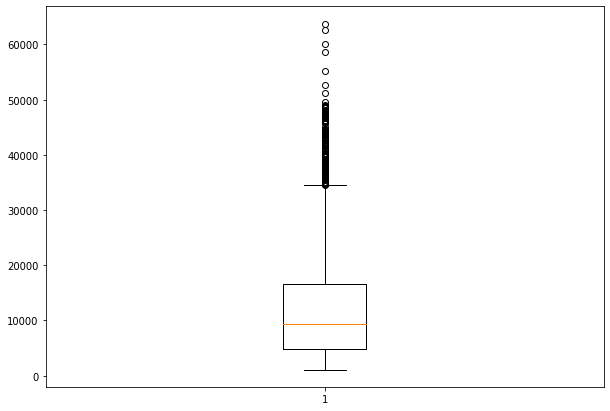

In [207]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(Y_quiz)
plt.show()

Se crea la data de text y train para el entrenamiento del modelo

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_quiz, Y_quiz, test_size=0.8, random_state=42)

Modelo de regresión básico

In [120]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(8227.503489330924,
 array([ 3521.79544142,  1932.67967589,   559.39655792,  -653.99858681,
        24171.06954998,   761.3529975 ,   799.24885523,  -392.2496595 ]))

In [121]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

MAPE de train

In [221]:
mean_absolute_percentage_error(y_train, y_train_pred)

0.37728149363969227

MAPE de test

In [222]:
mean_absolute_percentage_error(y_test, y_test_pred)

0.39739174443225683

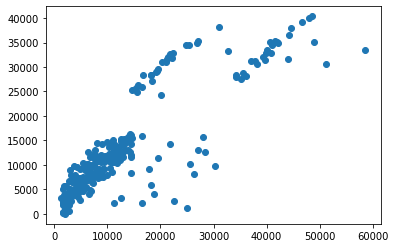

In [124]:
fig, ax = plt.subplots()
ax.scatter(y_train, y_train_pred)

plt.show()

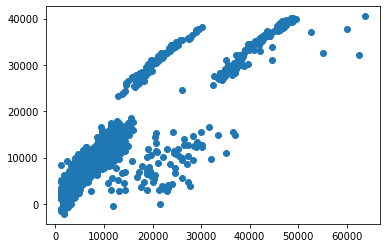

In [125]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred)

plt.show()

No se observan diferencias significativas entre el MAPE de train y test, por lo que se concluye que el modelo no está sobreajustado, aunque el error es de aproximadamente 39%, para lo cual se hace necesario comparar con otros modelos.

# **Polinomios**
Se calculan las X polinómicas de nivel 2 y nivel 3.

In [144]:
poly_features_2 = PolynomialFeatures(degree = 2, include_bias = False)
poly_features_3 = PolynomialFeatures(degree = 3, include_bias = False)
X_poly_train_2 = poly_features_2.fit_transform(X_train)
X_poly_test_2 = poly_features_2.fit_transform(X_test)
X_poly_train_3 = poly_features_3.fit_transform(X_train)
X_poly_test_3 = poly_features_3.fit_transform(X_test)

## Modelo polinomio de grado 2

In [205]:
lin_reg_poly_2 = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state = 42)
lin_reg_poly_2.fit(X_poly_train_2, y_train.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [150]:
y_train_pred_poly_2 = lin_reg_poly_2.predict(X_poly_train_2)
y_test_pred_poly_2 = lin_reg_poly_2.predict(X_poly_test_2)

In [204]:
mean_absolute_percentage_error(y_train, y_train_pred_poly_2) , mean_absolute_percentage_error(y_test, y_test_pred_poly_2)

(0.2542392498512564, 0.2979290768677052)

En este caso el error en train y test disminuye, aunque la diferencia entre ellos aumenta, por lo que se puede concluir que hay sobreajuste.

## Modelo polinomio de grado 3

In [158]:
lin_reg_poly_3 = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state = 42)
lin_reg_poly_3.fit(X_poly_train_3, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [153]:
y_train_pred_poly_3 = lin_reg_poly_3.predict(X_poly_train_3)
y_test_pred_poly_3 = lin_reg_poly_3.predict(X_poly_test_3)

In [203]:
mean_absolute_percentage_error(y_train, y_train_pred_poly_3) , mean_absolute_percentage_error(y_test, y_test_pred_poly_3)

(0.30645156016554087, 0.4604743234629635)

In [219]:
lin_reg_poly_2_lasso_1 = SGDRegressor(max_iter=1000, tol=1e-5, penalty='l1', alpha=0.5, eta0=0.01, n_iter_no_change=100, random_state = 42)
lin_reg_poly_2_lasso_1.fit(X_poly_train_2, y_train.ravel())
y_train_pred_poly_2_lasso_1 = lin_reg_poly_2_lasso_1.predict(X_poly_train_2)
y_test_pred_poly_2_lasso_1 = lin_reg_poly_2_lasso_1.predict(X_poly_test_2)

In [220]:
mean_absolute_percentage_error(y_train, y_train_pred_poly_2_lasso_1) , mean_absolute_percentage_error(y_test, y_test_pred_poly_2_lasso_1)

(0.25432635991730346, 0.2976410069813777)

In [188]:
lin_reg_poly_2_ridge_1 = SGDRegressor(max_iter=1000, tol=1e-5, penalty='l2', alpha=0.05, eta0=0.01, n_iter_no_change=100, random_state = 42)
lin_reg_poly_2_ridge_1.fit(X_poly_train_2, y_train.ravel())
y_train_pred_poly_2_ridge_1 = lin_reg_poly_2_ridge_1.predict(X_poly_train_2)
y_test_pred_poly_2_ridge_1 = lin_reg_poly_2_ridge_1.predict(X_poly_test_2)

In [201]:
mean_absolute_percentage_error(y_train, y_train_pred_poly_2_ridge_1) , mean_absolute_percentage_error(y_test, y_test_pred_poly_2_ridge_1)


(0.3595915587033793, 0.3755169227969145)